# Illustration of the treeSeg methodology 

The *treeSeg* algorithm is a method to segment a tree with response observations (e.g., phenotypes) at its tips into sub-branches with i.i.d. response distribution. It is implemented in the *treeSeg* R package. 

In the following we provide some explanation on how to use the treeSeg algorithm.

## Installing the treeSeg package

First, we need to install the package from GitHub. 

In [1]:
install.packages("devtools")


The downloaded binary packages are in
	/var/folders/bc/l4spbq41395cw9fxsmd1nxcr0000gn/T//RtmpJbnKJR/downloaded_packages


In [2]:
library(devtools)

install_github("merlebehr/treeSeg", subdir="TreeSeg")

Warning message:
“package ‘devtools’ was built under R version 3.5.2”Loading required package: usethis
Warning message:
“package ‘usethis’ was built under R version 3.5.2”Skipping install of 'treeSeg' from a github remote, the SHA1 (0e004e53) has not changed since last install.
  Use `force = TRUE` to force installation


## Example with simulated data

In the following, we illustrate the treeSeg algorithm based on a small simulated data example.

First we need to load the *treeSeg* package. 
We also attach the *ape* package, which helps with plotting and generating random trees as test setups.

In [3]:
library(treeSeg)
library(ape)


Loading required package: stepR
Warning message:
“package ‘stepR’ was built under R version 3.5.2”Successfully loaded stepR package version 2.0-3.
Several new functions are added in version 2.0-0. Some older functions are deprecated (still working) and may be defunct in a later version. Please read the documentation for more details.


We fix a seed to make things reproducible.

In [4]:
set.seed(1)

We consider a tree with $n = 200$ tips.

In [5]:
n <- 200 #number of observations


We generate a random binary tree, using the *rtree* function of the *ape* package.
The *ape* package also helps with plotting the tree.

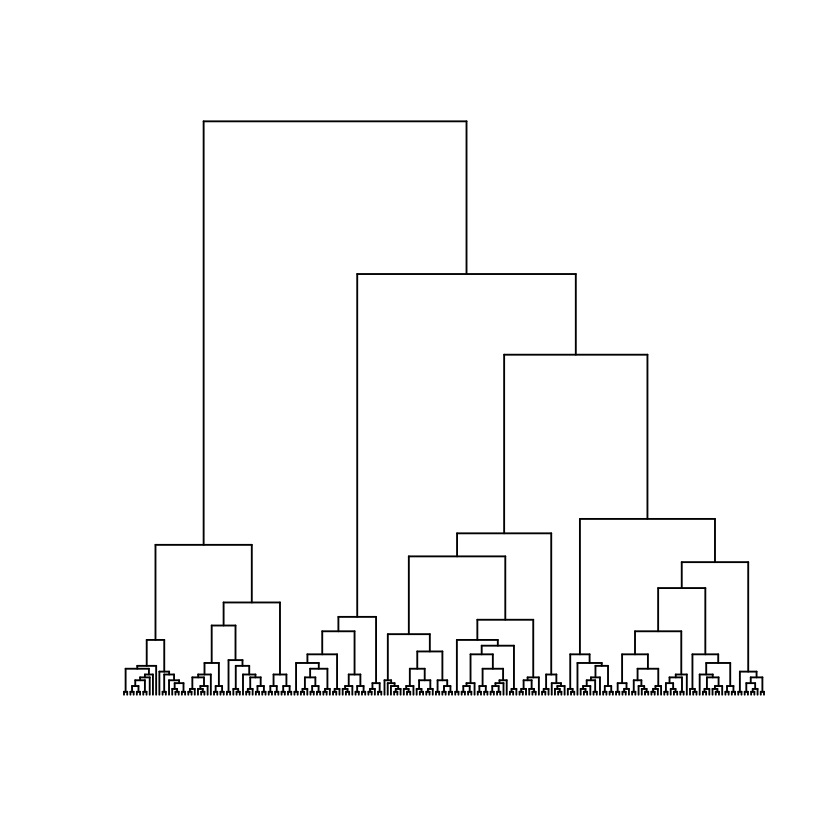

In [6]:
tree <- rtree(n, rooted = T) #generate tree

lwdEdge <- rep(1.5, dim(tree$edge)[1])
plot(tree, type = "phylogram", show.tip.label = F, use.edge.length = F, 
     node.pos = 1, direction = "downwards", show.node.label = F, edge.width = lwdEdge) 

We select two inner nodes (denoted as *active nodes*) in this tree, which correspond to a reasonably large sub-branch. When we generate the binary phenotypes at the tips, the observations in the respective sub-branches will have a different phenotype 1 probability than the rest.

In [7]:
activeNode1 <- n + 82 #active node 1
activeNode2 <- n + 154 #active node 2


The selected active nodes together with the respective sub-branches are shown in the plot. The active nodes are marked as black rectangles.

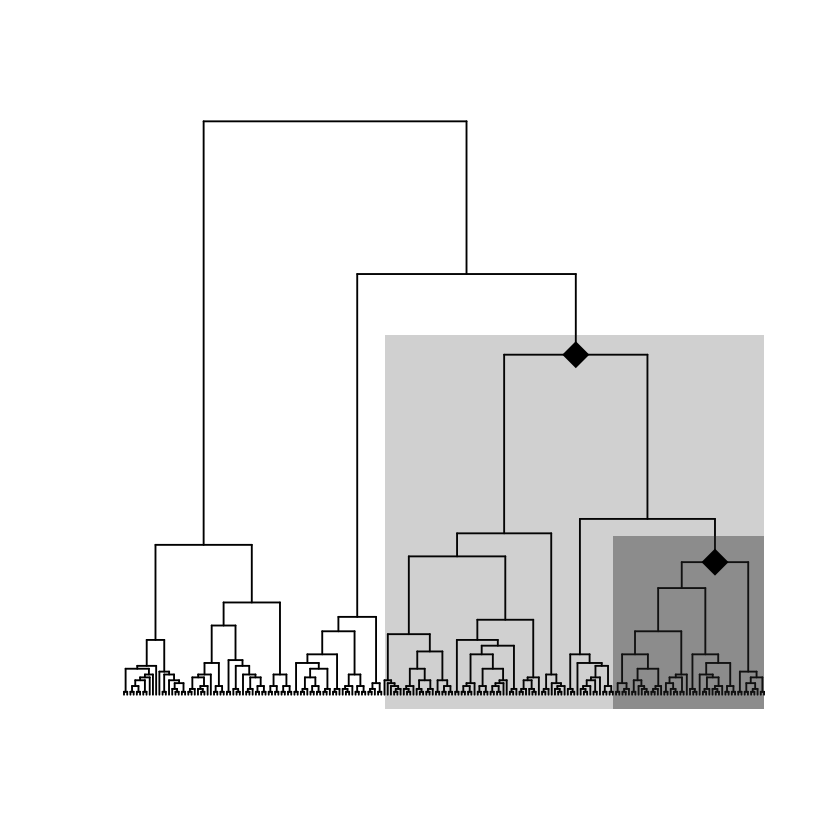

In [8]:
plot(tree, type = "phylogram", show.tip.label = F, use.edge.length = F, 
     node.pos = 1, direction = "downwards", show.node.label = F, edge.width = lwdEdge) 
rect(xleft = 82, xright = 200, ybottom = -5, ytop = 125, col= rgb(0.1,0.1,0.1,alpha=0.2),
     border = NA)
rect(xleft = 153, xright = 200, ybottom = -5, ytop = 55, col= rgb(0.2,0.2,0.2,alpha=0.4),
     border = NA)
nodelabels("", activeNode1, pch = 18, col = "black", frame = "none",cex = 3)
nodelabels("", activeNode2, pch = 18, col = "black", frame = "none", cex = 3)

Next we generate the phenotype observations. To access the offspring tips of a specific inner node in the tree, we can use the function *getOffspringTip* from the *treeSeg* package.

Tips in the main branch of the tree will be phenotype 1 with success probability 5%. 
Tips in the light gray sub-branch (offspring of active node 1) have an increased success probability of 42%, so their total success probability is 5% + 42% = 47%.
Tips in the dark gray sub-branch (offspring of active node 2)have an additional increase in success probability of 48%, which means that their total success probability is 5% + 42% + 48% = 95%.

In [9]:
offactiveNode1 <- getOffspringTip(activeNode1,tree) #offspring of active node 1
offactiveNode2 <- getOffspringTip(activeNode2,tree) #offspring of active node 2
prob1 <- 0.05
prob2 <- 0.42
prob3 <- 0.48
p <- prob1 + prob2 * is.element(1:n, offactiveNode1) + 
  prob3 * is.element(1:n, offactiveNode2) #success probabilities

Now we draw binary phenotype observations for the tips of the tree, with the respective success probability induced by the active nodes in the tree.

In [10]:
y <- rbinom(n, 1, p) #observations

We plot the tree together with the sampled phenotypes and respective success probabilities.

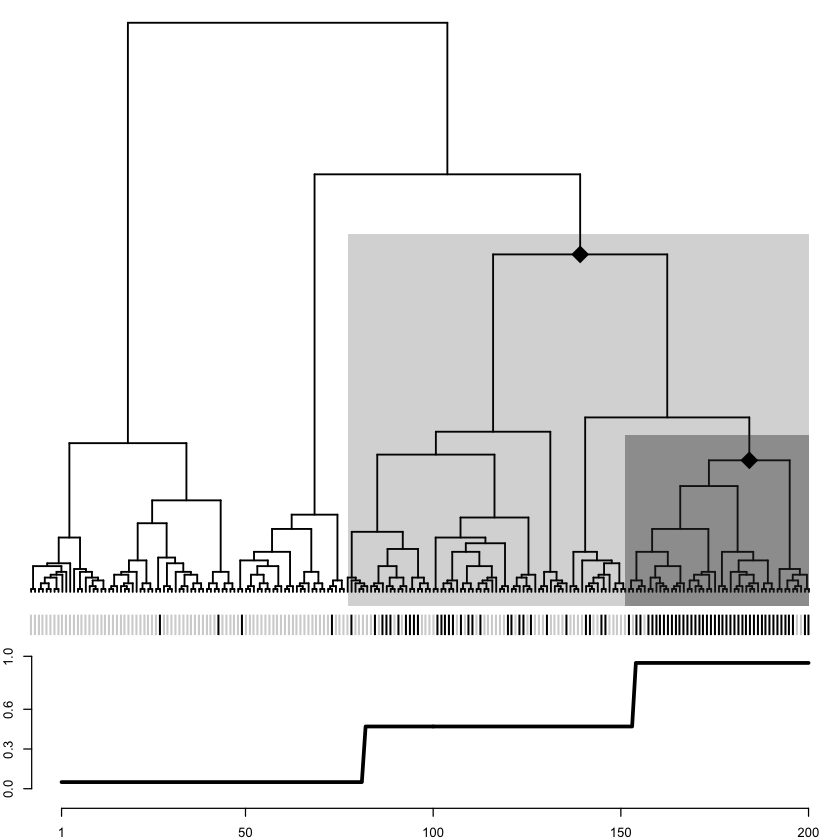

In [11]:
par(mar=c(0,0,0,0))

layout(matrix(1:3, nrow = 3), heights = c(3,0.1, 1))
plot(tree, type = "phylogram", show.tip.label = F, use.edge.length = F, 
     node.pos = 1, direction = "downwards", show.node.label = F, edge.width = lwdEdge) 
rect(xleft = 82, xright = 200, ybottom = -5, ytop = 125, col= rgb(0.1,0.1,0.1,alpha=0.2),
     border = NA)
rect(xleft = 153, xright = 200, ybottom = -5, ytop = 55, col= rgb(0.2,0.2,0.2,alpha=0.4),
     border = NA)
nodelabels("", activeNode1, pch = 18, col = "black", frame = "none",cex = 3)
nodelabels("", activeNode2, pch = 18, col = "black", frame = "none", cex = 3)

plot(1:n, rep(0,n), axes = F, col = c("lightgray", "black")[y + 1], pch = "|", cex = 2) 

par(mar = c(2,2,0.1,0.1))
plot(1:n, p, ylim = c(-0.1,1.1), type = "l", lwd = 3, axes = F)
axis(1, at = c(1,50,100,150,200), cex = 2)
axis(2, at = c(0,0.3,0.6,1) )

Next we select the only tuning parameter of the *treeSeg* algorithm, which is a confidence level $\alpha \in (0,1)$.

This probability $\alpha$ has a very natural interpretation: under a frequentist perspective, where each of the $n$ independent phenotype observations corresponds to a binary random variable with success probability inherited by some active ancestor node (in this example this would be active node 1 and 2 as indicated by rectangles in the tree), the estimated number of active nodes by treeSeg will be at most as large as the true number of active nodes (here $2$) with probability at least $1-\alpha$.

When a practitioner wants to be very conservative and ensure that the detected number of active nodes is indeed present in the signal, she should chose $\alpha$ very small.
On the other hand, to increase the power of the method to detect active nodes (at the unavoidable cost of increasing the risk of adding too many active components), she should chose $\alpha$ closer to 1.
Thereby, $\alpha$ directly bounds the overestimation probability.

Moreover, conditioned on the event that *treeSeg* estimated the number of active nodes correctly, it also provides honest (from a frequentist perspective) $1-\alpha$ confidence sets for all model parameters, as we will illustrate in the following.

In [12]:
alpha = 0.1

The main algorithm of the *treeSeg* package is implemented in the function *treeSeg*. 
As input, it receives the phenotype observations, the tree structure, and the confidence level $\alpha$.

In [13]:
ansSim <- treeSeg(y, tree, alpha = alpha)

In [14]:
str(ansSim)

List of 5
 $ numbAN   : int 2
 $ mlAN     : int [1:2] 282 354
 $ mlP      : num [1:200] 0.0494 0.0494 0.0494 0.0494 0.0494 ...
 $ confSetAN: int [1:5] 282 283 284 354 355
 $ confBandP: num [1:200, 1:2] 0.00811 0.00811 0.00811 0.00811 0.00811 ...


The output is a list of 5 elements:

- *numbAN* gives a single integer with the number of estimated active nodes. Here, *treeSeg* estimates the correct number of active nodes, namely 2.
- *mlAN* is an integer vector of length *numbAN* which gives the indexes of the estimated maximum likelihood (ml) active nodes in the tree. Note that, here, the estimates coincide with the true active nodes.
- *mlP* is a numeric vector having the same length as number of tips in the tree (and number of phenotype observations), which gives the estimated success probabilities.
- *confSetAN* is an integer vector with indexes of a $1-\alpha$ confidence set for the active nodes.
- *confBandP* is a matrix with two columns giving upper and lower values of a $1-\alpha$ confidence band for the phenotype success probabilities.

We illustrate the confidence set *cs* via orange rectangles at the respective tree nodes. Note that the true active nodes (here, coinciding with the estimated once and illustrated as black rectangles) are contained within the confidence set.

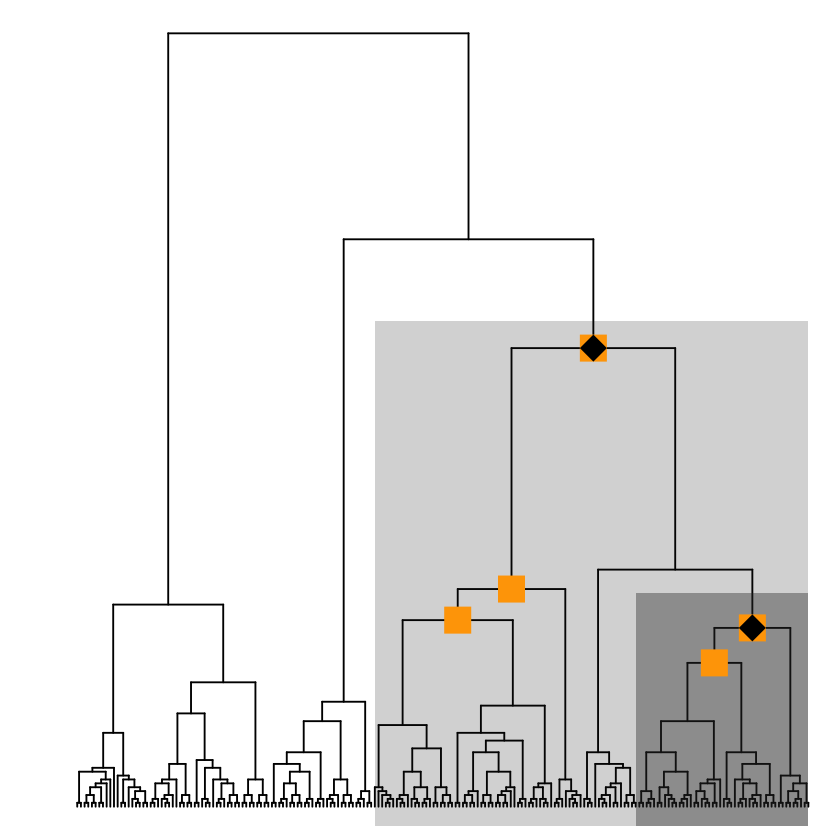

In [15]:
cs <- ansSim$confSetAN #confidence set for active nodes

lwdEdge <- rep(1.5, dim(tree$edge)[1])
par(mar = c(0.1,2,0.1,0.1))
plot(tree, type = "phylogram", show.tip.label = F, use.edge.length = F, 
     node.pos = 1, direction = "downwards", show.node.label = F, edge.width = lwdEdge) 
rect(xleft = 82, xright = 200, ybottom = -5, ytop = 125, col= rgb(0.1,0.1,0.1,alpha=0.2),
     border = NA)
rect(xleft = 153, xright = 200, ybottom = -5, ytop = 55, col= rgb(0.2,0.2,0.2,alpha=0.4),
     border = NA)
for(i in 1:length(cs)){
  nodelabels("", cs[i], pch = 15, col = "orange", frame = "none",cex = 3)
}
nodelabels("", activeNode1, pch = 18, col = "black", frame = "none",cex = 3)
nodelabels("", activeNode2, pch = 18, col = "black", frame = "none", cex = 3)


Next we consider the estimated phenotype probability and plot it together with the true one. The true underlying phenotype probability from which the data was drawn is shown in black and treeSeg's estimate is shown in orange.

As the active nodes are estimated correctly, the changes in phenotype distribution are also estimated exactly. This leads to a quite accurate estimate on individual branches for the respective phenotype distribution.

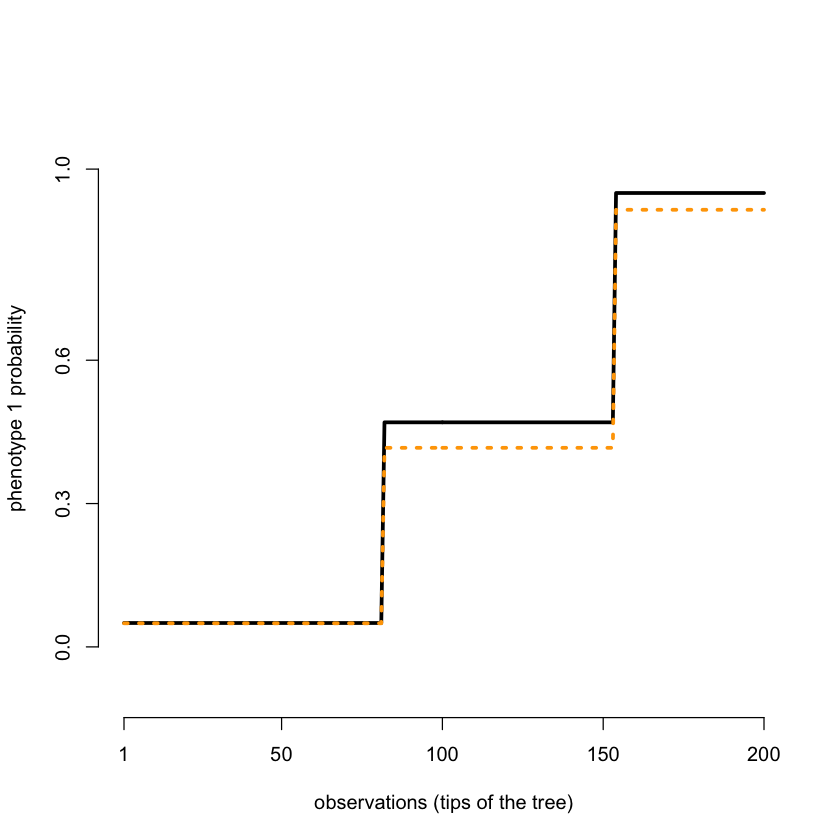

In [16]:
mlp <- ansSim$mlP #estimated success probabilities

plot(1:n, p, ylim = c(-0.1,1.1), type = "l", lwd = 3, axes = F, xlab = "observations (tips of the tree)", 
     ylab = "phenotype 1 probability")
axis(1, at = c(1,50,100,150,200), cex = 2)
axis(2, at = c(0,0.3,0.6,1) )
lines(1:n, mlp, lwd = 3, col = "orange", lty = 3)

TreeSeg also provides confidence bands for the phenotype 1 probability, which is shown in the following.
We observe that the true phenotype 1 probability is completely covered by the confidence band. In those regions where there is uncertainty about the branch-association of certain sub-groups, the confidence bands get very large, reflecting this uncertainty.

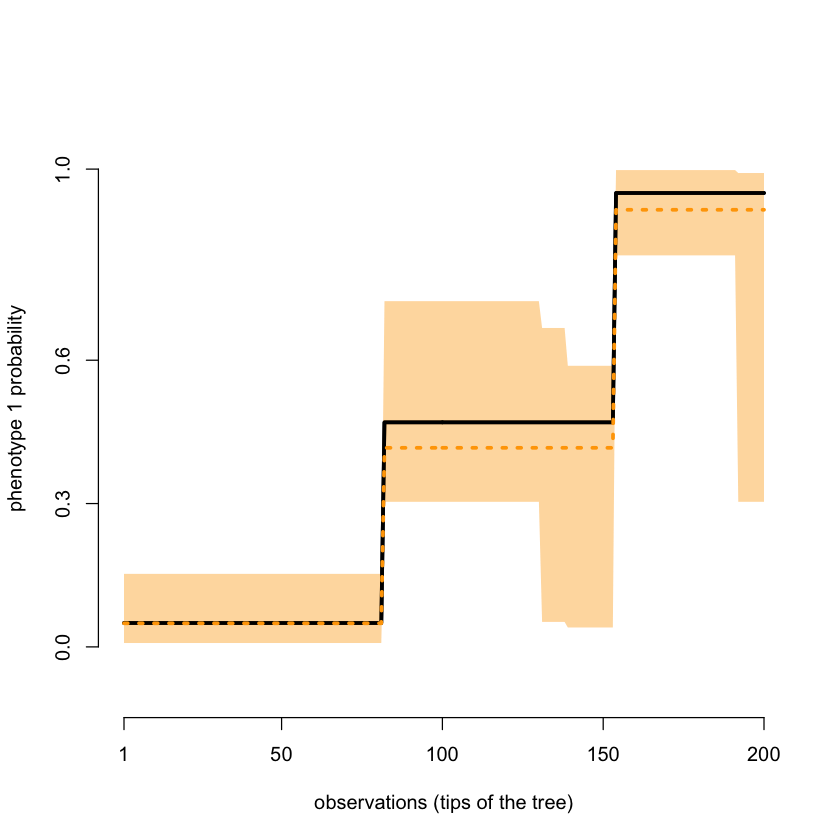

In [17]:
cb <- ansSim$confBandP #confidence band for success probabilities

plot(1:n, p, ylim = c(-0.1,1.1), type = "l", lwd = 3, axes = F, xlab = "observations (tips of the tree)", 
     ylab = "phenotype 1 probability")
axis(1, at = c(1,50,100,150,200), cex = 2)
axis(2, at = c(0,0.3,0.6,1) )

polygon(c(1:n, rev(1:n)), c(cb[,2], rev(cb[,1])),
        col = rgb(255, 165, 0, alpha = 100, maxColorValue = 255), border = NA)

lines(1:n, p, lwd = 3)
lines(1:n, mlp, lwd = 3, col = "orange", lty = 3)

Finally, we can combine all plots in a single one.

Note, for example, the observations in one of the most right branches. Compared to their high phenotype 1 probability, by chance, they have quite a lot of phenotype 0 observations. Thus, just from this data realization, one cannot rule out that the active node is shifted by one generation downwards. This would let those tips belong to the light gray sub-group instead of the dark gray sub-group. Hence, we obtain a high uncertainty in the phenotype confidence band. 

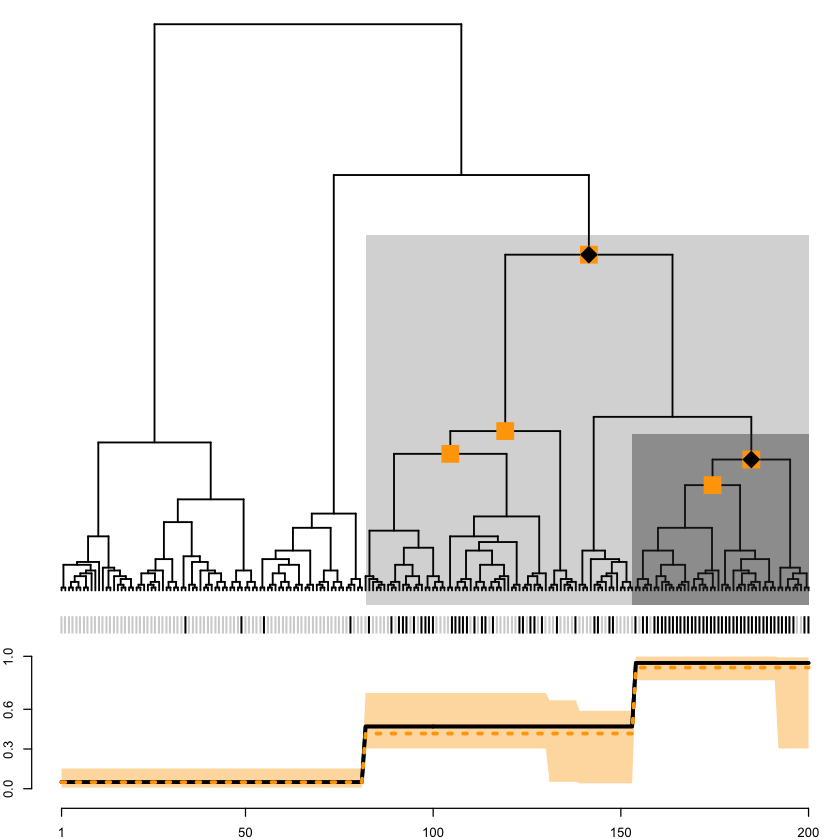

In [18]:
lwdEdge <- rep(1.5, dim(tree$edge)[1])
par(mar = c(0.1,2,0.1,0.1))
layout(matrix(1:3, nrow = 3), heights = c(3,0.1, 1))
plot(tree, type = "phylogram", show.tip.label = F, use.edge.length = F, 
     node.pos = 1, direction = "downwards", show.node.label = F, edge.width = lwdEdge) 
rect(xleft = 82, xright = 200, ybottom = -5, ytop = 125, col= rgb(0.1,0.1,0.1,alpha=0.2),
     border = NA)
rect(xleft = 153, xright = 200, ybottom = -5, ytop = 55, col= rgb(0.2,0.2,0.2,alpha=0.4),
     border = NA)
for(i in 1:length(cs)){
  nodelabels("", cs[i], pch = 15, col = "orange", frame = "none",cex = 3)
}
nodelabels("", activeNode1, pch = 18, col = "black", frame = "none",cex = 3)
nodelabels("", activeNode2, pch = 18, col = "black", frame = "none", cex = 3)

plot(1:n, rep(0,n), axes = F, col = c("lightgray", "black")[y + 1], pch = "|", cex = 2) 

par(mar = c(2,2,0.1,0.1))
plot(1:n, p, ylim = c(-0.1,1.1), type = "l", lwd = 3, axes = F)
axis(1, at = c(1,50,100,150,200), cex = 2)
axis(2, at = c(0,0.3,0.6,1) )

polygon(c(1:n, rev(1:n)), c(cb[,2], rev(cb[,1])),
        col = rgb(255, 165, 0, alpha = 100, maxColorValue = 255), border = NA)

lines(1:n, p, lwd = 3)
lines(1:n, mlp, lwd = 3, col = "orange", lty = 3)